# Convolutional Neural Network V1 Test 3

### Travail effectué
* CNN Initial
* CNN avec 5 couches
* Maxlen : 200

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.metrics import classification_report
from Fonctions_utils import f1_m, matrix_confusion, plot_score_model

In [2]:
df_train = pd.read_csv("../../data_models/df_train.csv")
df_val = pd.read_csv("../../data_models/df_val.csv")
df_test = pd.read_csv("../../data_models/df_test.csv")

In [3]:
sentences_train = df_train["text_clean"].values.astype(str)
sentences_val = df_val["text_clean"].values.astype(str)
sentences_test = df_test["text_clean"].values.astype(str)

y_train = df_train["Insult"].values
y_val = df_val["Insult"].values
y_test = df_test["Insult"].values

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

In [5]:
maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [6]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m, 'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           535050    
_________________________________________________________________
conv1d (Conv1D)              (None, 192, 128)          57728     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 594,079
Trainable params: 594,079
Non-trainable params: 0
_________________________________________________________________


2023-06-21 14:53:20.175903: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 14:53:20.176249: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=10)

## Performance

In [8]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

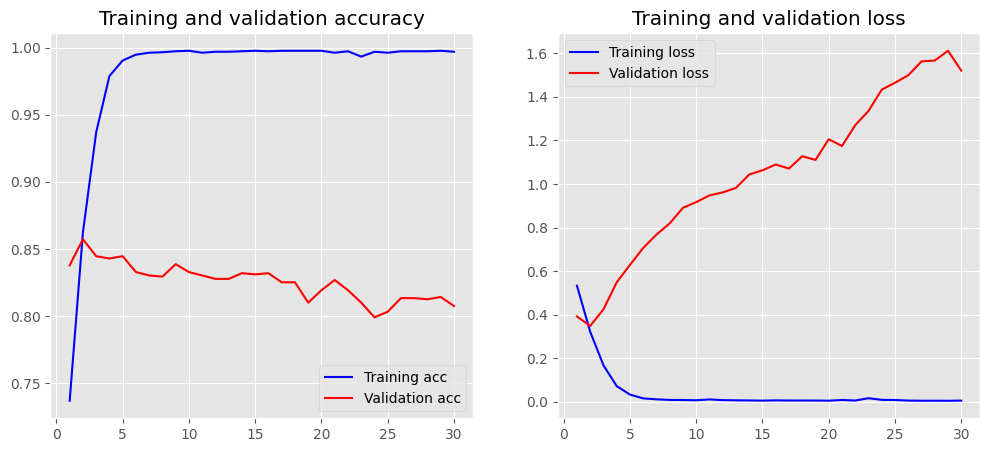

In [9]:
plot_score_model(history)

In [10]:
y_predict_test = model.predict(X_test)
y_predict_test2 = [round(item) for sublist in y_predict_test.tolist() for item in sublist]

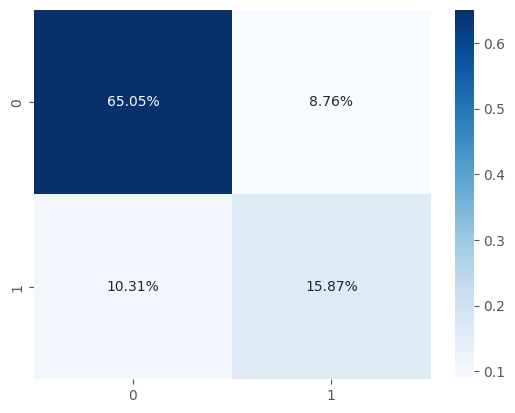

In [11]:
matrix_confusion(y_test, y_predict_test2)

In [12]:
target_names = ['Neutre', 'Insultant']
print(classification_report(y_test, y_predict_test2, target_names=target_names))

              precision    recall  f1-score   support

      Neutre       0.86      0.88      0.87      1954
   Insultant       0.64      0.61      0.62       693

    accuracy                           0.81      2647
   macro avg       0.75      0.74      0.75      2647
weighted avg       0.81      0.81      0.81      2647



In [13]:
df_test2 = df_test.copy()
df_test2["predi"] = y_predict_test2
diff = df_test2[df_test2["Insult"] != df_test2["predi"]]

In [14]:
diff

,Insult,text_clean,predi
7,0,how about we accept fact and patiently wait fo...,1
8,1,to engage in an intelligent debate with you is...,0
14,0,cnn support harcore mass murdering islamist te...,1
23,1,go loving,0
32,0,zimmerman and his wife look like brother and s...,1
...,...,...,...
2628,1,another dumb comment put america first before ...,0
2629,1,go use google simpleton that is how the word i...,0
2635,0,melissa i have loved you from the first day i ...,1
2637,1,obviously the comic book you read have done yo...,0


In [15]:
diff.iloc[0,1]

'how about we accept fact and patiently wait for you to back up your claim'

In [16]:
diff.iloc[479,1]

'is that why obama ha borrowed more money a president in year than any other sitting president in u history you are delusional'